In [1]:
#balancing (for sandra) 
library(themis)

ups_recipe <- recipe(Class ~ ., data = rare_cancer) |>
  step_upsample(Class, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

ERROR: Error in library(themis): there is no package called ‘themis’


#  Exploring the relative significance of various health factors in determining the presence of Heart Disease

## Introduction

The term "Heart Disease" refers to different types of heart conditions, with the most common being Coronary Artery Disease (CAD), which limits bloodflow to the heart and can cause heart attacks.  High blood pressure and high blood cholesterol levels are primary risk factors for heart disease. Blood pressure, when too high, can put stress on the arteries in addition to organs such as the heart and kidneys. Cholesterol is a waxy, fat-like substance that can build up on the walls of the arteries and reduce blood flow to the heart. Resting heart rate is also a general measure of heart health, with lower heart rates indicating more efficient heart function. These variables (Blood Pressure, Cholesterol, and Resting Heart Rate) can be accounted for and managed with the help of medications or lifestyle changes. Since these factors can be controlled, they are likely the most important in studying as predictors of heart disease. 

We will be trying to find which of these variables has the greatest correlation to the presence of heart disease. This will allow us to determine which factor is most important for someone to reduce their risk for heart disease, leading us to our central question: Which of those manageable predictors of Heart Disease is most important in reducing the risk of Heart Disease?

To do this we are using the Heart Disease Dataset which contains databases for four locations: Cleveland, Hungary, Switzerland, and the VA Long Beach. For our project we will be using the Cleveland database. Each database contains variables such as sex, age, cholesterol, blood pressure, fasting blood sugar, maximum heart rate, chest pain, and more. The dataset was created as part of comparative study testing the reliability of a new discriminant function in estimating the probability of Cornonary Disease.


## Preliminary Exploratory Data Analysis

We began by reading our data in from the web, which we then cleaned and wrangled for clarity and ease of manipulation.

In [14]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(repr)

# Load in libaries

#Set URL of dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

#Set file path of dataset
file_path <- "processed.cleveland.data"

#Get character vector of Column Names of Dataset
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                  "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target")

#Download dataset into R
download.file(url, destfile = file_path, method = "auto")

#Read dataset into heart_csv
heart_csv <- read_delim("processed.cleveland.data", delim = ",", col_names = column_names)

#Clean dataset
heart_data <- heart_csv |>
    select(age, sex, chol, trestbps, target) |>
    mutate(target = as_factor(ifelse(target > 0, "have heart disease", "no heart disease"))) |>
    mutate(sex = (ifelse(sex == 0, "female", "male")))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chol,trestbps,target
<dbl>,<chr>,<dbl>,<dbl>,<fct>
63,male,233,145,no heart disease
67,male,286,160,have heart disease
67,male,229,120,have heart disease
37,male,250,130,no heart disease
41,female,204,130,no heart disease
56,male,236,120,no heart disease
62,female,268,140,have heart disease
57,female,354,120,no heart disease
63,male,254,130,have heart disease


## Training and Testing Data

In [15]:
#Set seed and Create training and testing split for dataset
set.seed(1234)
heart_split <- initial_split(heart_data, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

## Summary of Data
We are hoping to determine the most relevant causes of heart disease that a patient can manage with medication or lifestyle changes. So we will find the mean values of the variables we plan to use, and seperate them by the presence of heart disease. From this we hope to see if there is any obvioius, initial corelation between heart disease and each of our variables.
We will summarize the mean cholesterol and resting blood pressure (on admission to the hospital). 

In [17]:
#Create summary dataset 
summary_heart <- heart_train |>
    group_by(target) |>
    summarize(mean_chol = mean(chol, na.rm = TRUE), mean_trestbps = mean(trestbps, na.rm = TRUE))
    
summary_heart

target,mean_chol,mean_trestbps
<fct>,<dbl>,<dbl>
no heart disease,243.0325,129.5691
have heart disease,247.9327,133.4615


We can see that the mean values differentiated by sex are different, while this is not enough to show an actual corelation, we can at least see that there isn't no change.

## Training Data Visualization
No we will see if age is a significant factor in whether a patient has heart disease. Since a patient cannot control their age, we will use this visualization to decide if we need to include a cut-off point for our data.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


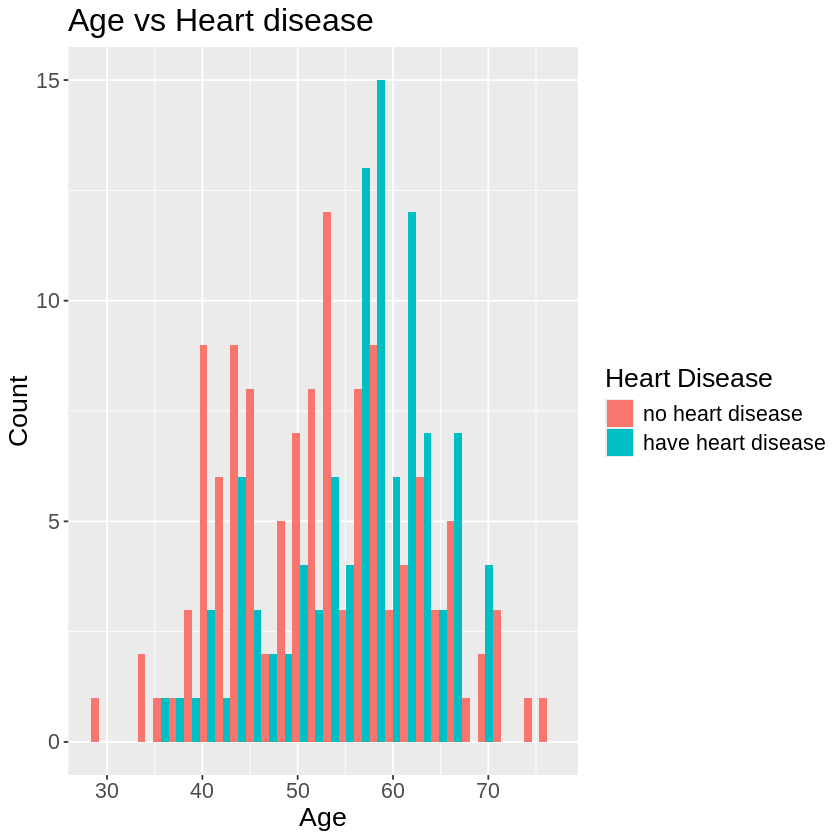

In [18]:
age_histogram <-   ggplot(heart_train, aes(x = age, fill = target)) +
                     geom_histogram(position = 'dodge') +
                     labs(x = "Age", y = "Count", fill = "Heart Disease") +
                     ggtitle("Age vs Heart disease") +
                     theme(text=element_text(size=16))
age_histogram

We can see that minimal people had heart disease before the age of 35. Therefore we will only work with data in which their age is over 35. We will filter our data, and then create new training and testing data with the same seed.

In [22]:
set.seed(1234)
heart_data <- heart_data |> filter(age > 35)
heart_split <- initial_split(heart_data, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

We will also plot some prelimanary graphs to get a better understanding of our data. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


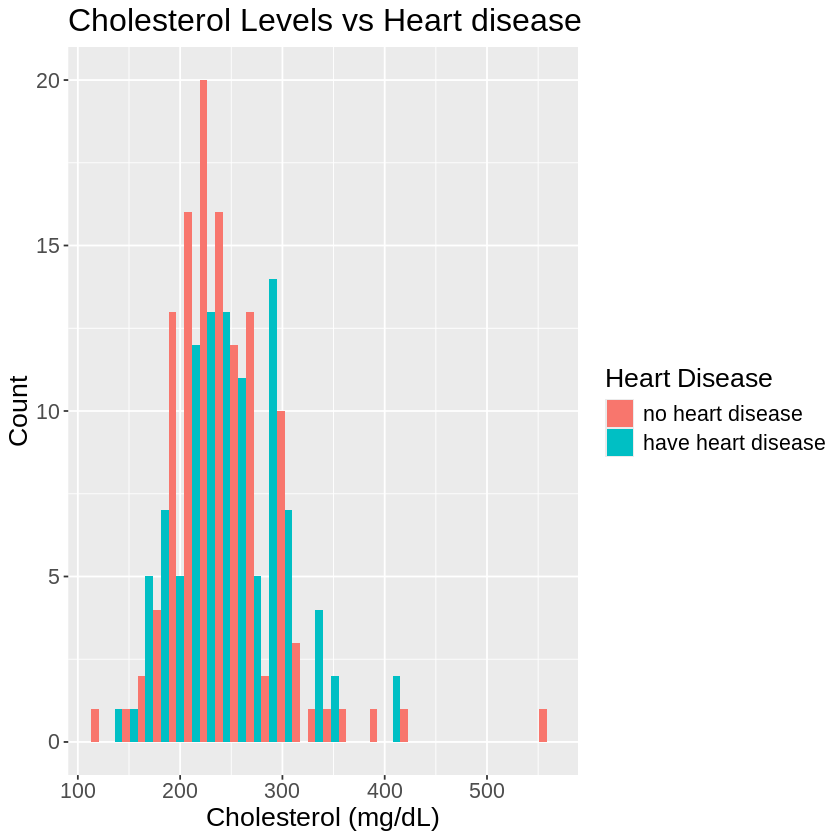

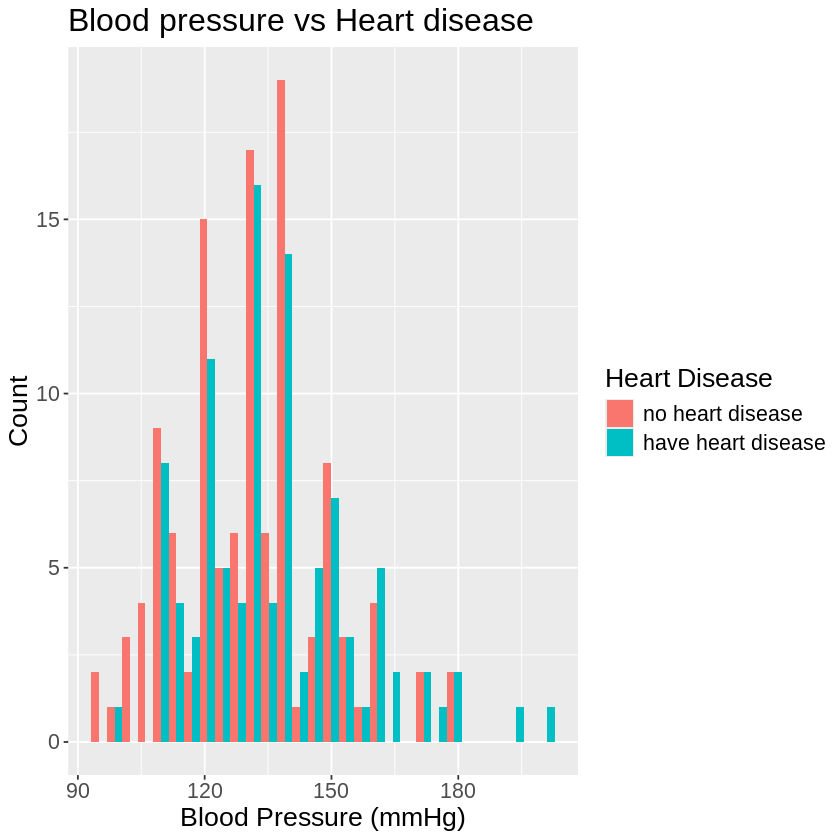

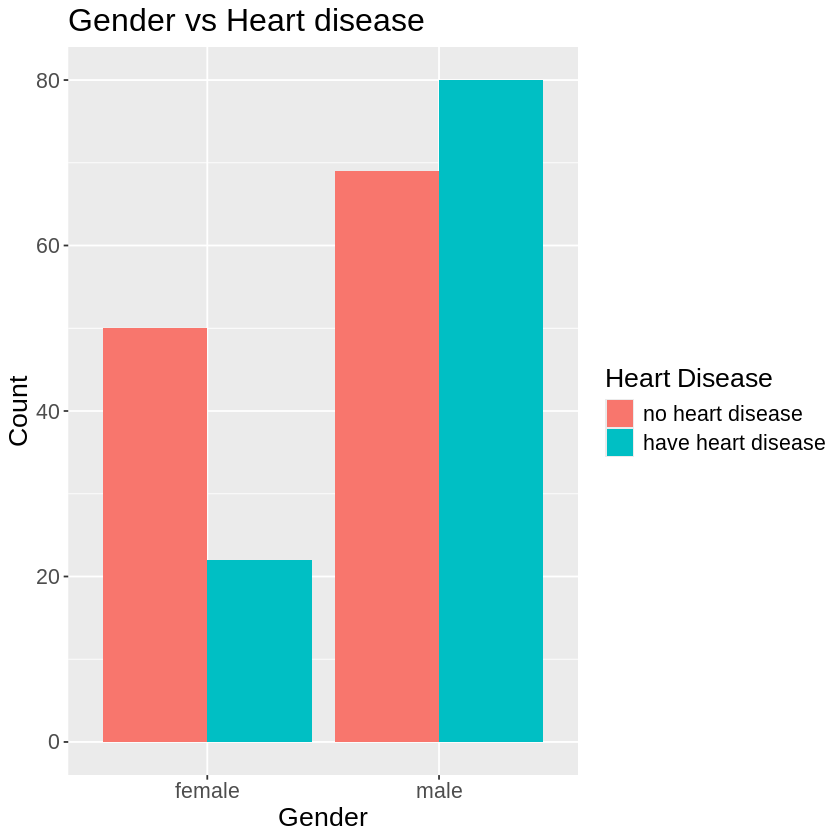

In [24]:
chol_histogram <-   ggplot(heart_train, aes(x = chol, fill = target)) +
                     geom_histogram(position = 'dodge') +
                     labs(x = "Cholesterol (mg/dL)", y = "Count", fill = "Heart Disease") +
                     ggtitle("Cholesterol Levels vs Heart disease") +
                     theme(text=element_text(size=16))
chol_histogram

trestbps_histogram <-   ggplot(heart_train, aes(x = trestbps, fill = target)) +
                        geom_histogram(position = 'dodge') +
                        labs(x = "Blood Pressure (mmHg)", y = "Count", fill = "Heart Disease") +
                        ggtitle("Blood pressure vs Heart disease") +
                        theme(text=element_text(size=16))
trestbps_histogram

gender_bar <-   ggplot(heart_train, aes(x = sex, fill = target)) +
                geom_bar(position = 'dodge') +
                labs(x = "Gender", y = "Count", fill = "Heart Disease") +
                ggtitle("Gender vs Heart disease") +
                theme(text=element_text(size=16))
gender_bar

## Methods

### Variables Used
We have made the data set smaller and more manageable by using only the cholesterol, resting heart rate, blood pressure, age, and sex variables. We will also keep the column that determines whether or not the patient received a diagnosis of heart disease in order to train and then test our model. 
### Data Analysis
After cleaning the data and retaining columns for each of our variables, we will split the dataset by sex. We will perform a classification using each variable for one sex and compare the accuracies of each model for that sex. We are splitting by sex because from our previous summaries, we can see that there is a significant difference between male and female levels of heart disease. Each classification will start with a training dataset that will be used to create a recipe. We will perform 5-fold cross-validation on the training set in order to find the best k value. Then, we'll build a model using that k value and the training dataset. Finally, we'll use that model to pass the testing dataset through and evaluate its' accuracy. This process will be repeated for each variable for males and then each variable for females.
### Data Visualization
We will visualize results with bar plots that represent the accuracy of each variable, separated by sex. This will demonstrate which variables are best at predicting a diagnosis of heart disease and highlight any discrepancies between sexes. Additionally, we will have confusion matrixes for each variable. We will also have tibbles with each variables' accuracy for each sex. 


In [52]:
heart_train_m <- heart_train |> filter (sex == "male")
heart_test_m <- heart_test |> filter (sex == "male")
heart_train_f <- heart_train |> filter (sex == "female")
heart_test_f <-heart_test |> filter (sex == "female")

#Recipe for male cholesterol data
mchol_recipe <- recipe(target ~ chol, data = heart_train_m) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#Standard 5,10 vfolds on male data
m_vfold5 <- vfold_cv(heart_train_m, v = 5, strata = target)
m_vfold10 <- vfold_cv(heart_train_m, v = 10, strata = target)

#Standard knn_spec without tuning
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

#Finding standard error for different vfolds for male cholesterol data
knn_mchol_metrics5 <- workflow() |>
    add_recipe(mchol_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = m_vfold5) |>
    collect_metrics() 
knn_mchol_metrics10 <- workflow() |>
    add_recipe(mchol_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = m_vfold10) |>
    collect_metrics() 
#knn_mchol_metrics5
#knn_mchol_metrics10
#We see that standard error is least when vfold is 5, so we continue with 5

#Standard tuned knn_spec function
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#Standard kvals for tuning
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

knn_mchol_accuracies <- workflow() |>
    add_recipe(mchol_recipe) |>
    add_model(knn_spec_tuned) |>
    tune_grid(resamples = m_vfold5, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

best_k_mchol <- knn_mchol_accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
#best_k_mchol
#So we will choose a k of 3

#final knn_Spec for m_chol
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_mchol) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_mchol <- workflow() |>
  add_recipe(mchol_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_train_m)

mchol_test_predictions <- predict(knn_fit_mchol, heart_test_m) |>
  bind_cols(heart_test_m) |>
  metrics(truth = target, estimate = .pred_class) |>
  filter(.metric == "accuracy")
mchol_test_predictions


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4807692
